In [1]:
import parselmouth
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import librosa
import glob
import librosa.display

C:\Users\thiri\Anaconda3\envs\Emotion\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


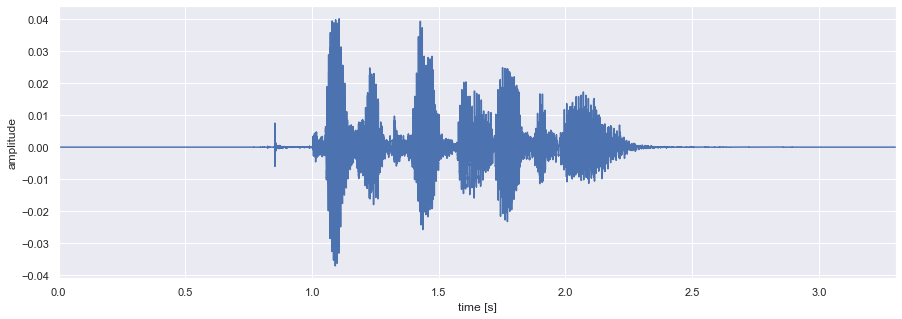

In [12]:
sns.set() # Use seaborn's default style to make attractive graphs

# Plot nice figures using Python's "standard" matplotlib library
snd = parselmouth.Sound("../../Resources/data/Audiofile/03-01-01-01-01-01-01.wav")
plt.figure(figsize=(15, 5))
plt.plot(snd.xs(), snd.values.T)
plt.xlim([snd.xmin, snd.xmax])
plt.xlabel("time [s]")
plt.ylabel("amplitude")
#plt.show() or plt.savefig("Resources/images/sound.png")
plt.savefig("../../Resources/images/Parcelmouth_sound.png")

C:\Users\thiri\Anaconda3\envs\Emotion\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


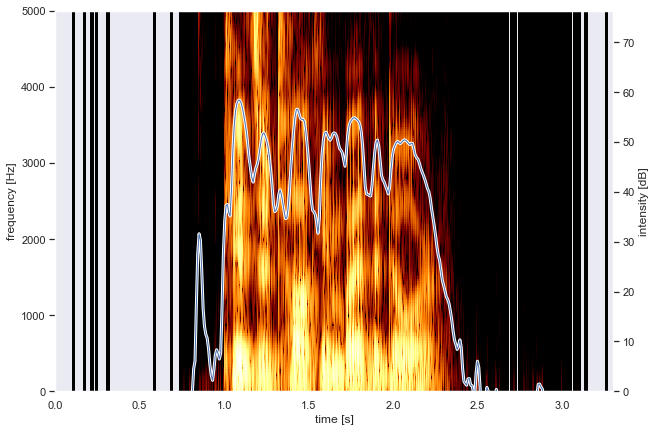

In [13]:
def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=3, color='w')
    plt.plot(intensity.xs(), intensity.values.T, linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")

intensity = snd.to_intensity()
spectrogram = snd.to_spectrogram()
plt.figure(figsize=(10, 7))
draw_spectrogram(spectrogram)
plt.twinx()
draw_intensity(intensity)
plt.xlim([snd.xmin, snd.xmax])
#plt.show() or plt.savefig("../../Resources/images/spectrogram.png")
plt.savefig("../../Resources/images/Pspectrogram.png")

C:\Users\thiri\Anaconda3\envs\Emotion\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


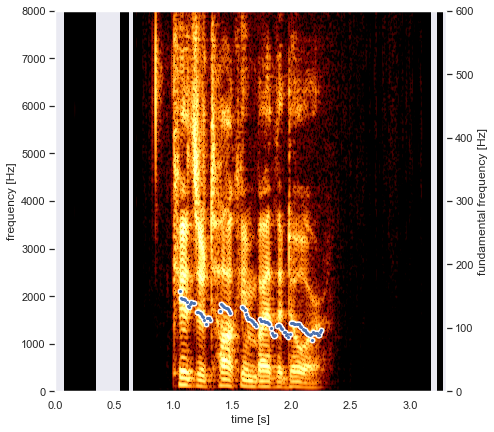

In [14]:
def draw_pitch(pitch):
    # Extract selected pitch contour, and
    # replace unvoiced samples by NaN to not plot
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2)
    plt.grid(False)
    plt.ylim(0, pitch.ceiling)
    plt.ylabel("fundamental frequency [Hz]")

pitch = snd.to_pitch()
# If desired, pre-emphasize the sound fragment before calculating the spectrogram
pre_emphasized_snd = snd.copy()
pre_emphasized_snd.pre_emphasize()
spectrogram = pre_emphasized_snd.to_spectrogram(window_length=0.03, maximum_frequency=8000)
plt.figure(figsize=(7, 7))
draw_spectrogram(spectrogram)
plt.twinx()
draw_pitch(pitch)
plt.xlim([snd.xmin, snd.xmax])
#plt.show() or plt.savefig("Resources/images/spectrogram_0.03.png")
plt.savefig("../../Resources/images/pspectrogram_0.03.png")

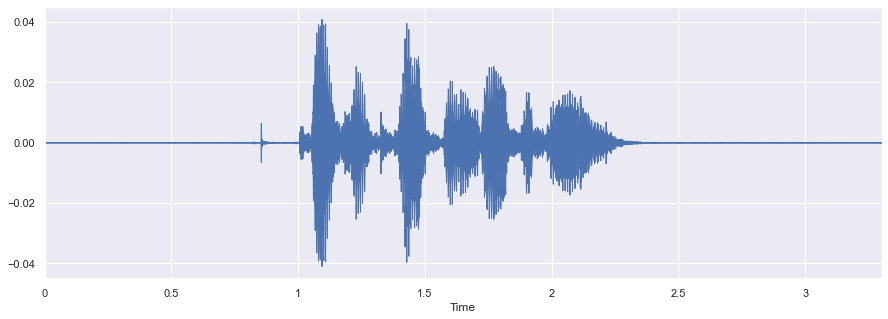

In [6]:
# % pylab inline

data, sampling_rate = librosa.load("../../Resources/data/Audiofile/03-01-01-01-01-01-01.wav")
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)
plt.savefig("../../Resources/images/librosa_sound.png")

In [15]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('../../Resources/data/Audiofile/03-01-01-01-01-01-01.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

livedf2= pd.DataFrame(data=livedf2)
livedf2 = livedf2.stack().to_frame().T
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-65.802139,-65.802139,-65.802139,-65.802139,-65.802139,-65.802139,-65.802139,-65.802139,-65.802139,-65.802139,...,-58.061974,-62.3517,-65.670807,-65.802139,-65.562431,-65.705978,-65.587151,-64.072983,-65.273407,-64.805664


In [16]:
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
json_file = open('../../Resources/data/analysis_output/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("../../Resources/data/saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

NameError: name 'model_from_json' is not defined

In [17]:
twodim= np.expand_dims(livedf2, axis=2)
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

NameError: name 'loaded_model' is not defined

In [ ]:
livepreds

In [ ]:
livepreds1=livepreds.argmax(axis=1)
liveabc = livepreds1.astype(int).flatten()
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions